Program for comparing the adjoint odeint method and the NN-interpolator method in two tasks:
1. They are trained on a fixed synthetic input with the goal of finding optimal parameters yielding the true EF,
2. They are trained on a synthetic dataset of 400 patients (randomly taken from the Echonet dataset) with the goal of learning to predict optimal circuit parameters yielding correct EFs for the patients.

To run this code (which has been made in a Google Colab notebook), the following three files have to be saved in the Drive:
- net_weights__weight.pt
- input_450patients_echonet.pt
- labels_450patients_echonet.pt.

Summarized results: when the integration time is too high (e.g. 15 cardiac cycles) the odeint adjoint method takes extremely long times for only one iteration (several minutes, and often gets error due to stiffness, even when using 'euler' integration and low time step). On the other hand, if the integration time is low (eg 1 cardiac cycle) the predictions made by the odeint adjoint method are far from the correct ones since it takes 5-15 cardiac cycles of the simulation to reach the steady state.

In [1]:
# -*- coding: utf-8 -*-

!pip3 install torchdiffeq

import os
import argparse
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

parser = argparse.ArgumentParser('ODE demo')

parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000) #size of true_y and pred_y and t (n of timepoints for the diff eq in odeint)
parser.add_argument('--batch_time', type=int, default=10) #batch_t takes the first batch_time(=10) first elements of t
parser.add_argument('--batch_size', type=int, default=1)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
args = parser.parse_args(args=[])

from torchdiffeq import odeint_adjoint as odeint
from scipy.integrate import odeint as odeint_standard

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')


Pv loop simulator (and returns v_i):

In [2]:
### ODE: for each t (here fixed), gives dy/dt as a function of y(t) at that t, so can be used for integrating the vector y over time
#it is run for each t going from 0 to tmax
def heart_ode(y, t, Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emax, Emin, Tc):
    x1, x2, x3, x4, x5 = y #here y is a vector of 5 values (not functions), at time t, used for getting (dy/dt)(t)
    P_lv = Plv(x1,Emax,Emin,t,Tc)
    dydt = [r(x2-P_lv)/Rm-r(P_lv-x4)/Ra, (x3-x2)/(Rs*Cr)-r(x2-P_lv)/(Cr*Rm), (x2-x3)/(Rs*Cs)+x5/Cs, -x5/Ca+r(P_lv-x4)/(Ca*Ra), (x4-x3-Rc*x5)/Ls]
    return dydt

def r(u):
    return max(u, 0.)

#returns Plv at time t using Elastance(t) and Vlv(t)-Vd=x1
def Plv(x1, Emax, Emin, t, Tc):
    return Elastance(Emax,Emin,t, Tc)*x1

#returns Elastance(t)
def Elastance(Emax,Emin,t, Tc):
    t = t-int(t/Tc)*Tc #can remove this if only want 1st ED (and the 1st ES before)
    tn = t/(0.2+0.15*Tc)
    return (Emax-Emin)*1.55*(tn/0.7)**1.9/((tn/0.7)**1.9+1)*1/((tn/1.17)**21.9+1) + Emin

def pvloop_simulator(Tc, start_v, Emax, Emin, Rm, Ra, Vd, N, plotloops, plotpressures, plotflow):
    startp = 75.
    Rs = 1.0
    Rc = 0.0398
    Ca = 0.08
    Cs = 1.33
    Cr = 4.400
    Ls = 0.0005

    start_pla = float(start_v*Elastance(Emax, Emin, 0, Tc))
    start_pao = startp
    start_pa = start_pao
    start_qt = 0 #aortic flow is Q_T and is 0 at ED, also see Fig5 in simaan2008dynamical
    y0 = [start_v, start_pla, start_pa, start_pao, start_qt]

    t = np.linspace(0, Tc*N, int(60000*N)) #spaced numbers over interval (start, stop, number_of_steps), 60000 time instances for each heart cycle
    #changed to 60000 for having integer positions for Tmax

    sol = odeint_standard(heart_ode, y0, t, args = (Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emax, Emin, Tc)) #t: list of values

    result_Vlv = np.array(sol[:, 0]) + Vd
    result_Plv = np.array([Plv(v, Emax, Emin, xi, Tc) for xi,v in zip(t,sol[:, 0])])

    ved = sol[(N-1)*60000, 0] + Vd
    ves = sol[200*int(60/Tc)+9000+(N-1)*60000, 0] + Vd # 0.2 s = ?. Tc s = 60000 -> 1 s = int(60000/Tc) -> x s = int( x * 60000/Tc)
    ef = (ved-ves)/ved * 100.

    X = [result_Vlv[(N-1)*60000 +12000], result_Vlv[(N-1)*60000 + 24000], result_Vlv[(N-1)*60000 +36000], result_Vlv[(N-1)*60000 +48000]] #input: volumes at times 0.2Tc, 0.4Tc, 0.6Tc, 0.8Tc = 18000, 30000, 48000

    minv = min(result_Vlv[(N-1)*60000:N*60000-1])
    minp = min(result_Plv[(N-1)*60000:N*60000-1])
    maxp = max(result_Plv[(N-1)*60000:N*60000-1])

    ved2 = sol[(N-1)*60000 - 1, 0] + Vd
    isperiodic = 0
    if (abs(ved-ved2) > 5.): isperiodic = 1

    if plotloops:
      plt.plot(result_Vlv[(N-2)*60000:(N)*60000], result_Plv[(N-2)*60000:N*60000])
      plt.xlabel("LV volume (ml)")
      plt.ylabel("LV pressure (mmHg)")
      plt.show()

    if plotpressures:
      result_Pla = np.array(sol[:, 1])
      result_Pa = np.array(sol[:, 2])
      result_Pao = np.array(sol[:, 3])
      plt.plot(t[(N-2)*60000:(N)*60000], result_Plv[(N-2)*60000:N*60000], label='LV P')
      plt.plot(t[(N-2)*60000:(N)*60000], result_Pao[(N-2)*60000:N*60000], label='Aortic P')
      plt.plot(t[(N-2)*60000:(N)*60000], result_Pa[(N-2)*60000:N*60000], label='Arterial P')
      plt.plot(t[(N-2)*60000:(N)*60000], result_Pla[(N-2)*60000:N*60000], label='Left atrial P')
      plt.xlabel("Time (s)")
      plt.ylabel("Pressure (mmHg)")
      plt.legend(loc='upper right', framealpha=1)
      plt.show()

    if plotflow:
      result_Q = np.array(sol[:, 4])
      plt.plot(t[(N-2)*60000:(N)*60000], result_Q[(N-2)*60000:N*60000])
      plt.xlabel("Time (s)")
      plt.ylabel("Blood flow (ml/s)")

    return X, ved, ves, ef #, minv, minp, maxp, isperiodic

Define Neural ODE-based model:

In [3]:
## fixed parameters of the circuit:
Rs = 1.0
Rc = 0.0398
Ca = 0.08
Cs = 1.33
Cr = 4.400
Ls = 0.0005

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

## normalizes the parameters to realistic ranges (intervals of validity: same as those used for creating the NN-interpolator)
class Normalizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lower = torch.tensor([0.4, 0., 0.5, 0.02, 0.005, 0.0001, 4.], dtype=torch.float32)
        self.upper = torch.tensor([1.7, 280., 3.5, 0.1, 0.1, 0.25, 25.], dtype=torch.float32)
    def forward(self, inputs):
        return torch.sigmoid(inputs) * (self.upper - self.lower) + self.lower

class ODEFunc(nn.Module): #takes y, t and returns dydt = NN(y,t). NN: defined in self.net (NN: (y**3, t**3):2D->50->tanh->2D=dydt)
    def __init__(self, tc, emax, emin, rm, ra, vd):
        super(ODEFunc, self).__init__()
        self.tc = tc
        self.emax = emax
        self.emin = emin
        self.rm = rm
        self.ra = ra
        self.vd = vd

    def forward(self, t, y):

        global Rs, Rc, Cs, Cr, Ca, Ls
        dydt = torch.zeros_like(y)

        tn = ( t - int(t/self.tc) * self.tc ) / (0.2+0.15 * self.tc)
        P_lv = ( (self.emax-self.emin)*1.55*(tn/0.7)**1.9/((tn/0.7)**1.9+1)*1/((tn/1.17)**21.9+1) + self.emin ) * y[0]

        dydt[0] = torch.relu(y[1] - P_lv) / self.rm - torch.relu(P_lv - y[3]) / self.ra
        dydt[1] = (y[2]-y[1]) / (Rs*Cr) - torch.relu(y[1]-P_lv) / (Cr*self.rm)
        dydt[2] = (y[1]-y[2]) / (Rs*Cs) + y[4] / Cs
        dydt[3] = - y[4] / Ca + torch.relu(P_lv-y[3]) / (Ca*self.ra)
        dydt[4] = (y[3]-y[2]-Rc*y[4]) / Ls

        return dydt

class NeuralODE(nn.Module):
    def __init__(self):
        super(NeuralODE, self).__init__()
        ## equivalent to transformations into the transformations video->tensor with the 7 parameters
        self.fc1 = nn.Linear(4, 64).double()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 7).double()
        self.norm1 = Normalizer()

    def forward(self, x):

        ## next two lines would be the transformation 3DCNN: video -> 7 parameters; pars = the 7 parameters normalized
        pars = self.norm1(self.fc2(self.relu(self.fc1(x)))) #pars: (Tc, startv, emax, emin, rm, ra, Vd)

        y0 = torch.stack([pars[1], pars[1] * pars[3], torch.tensor(75.), torch.tensor(75.), torch.tensor(0.)], dim=0) #y0 = (startv, startv * emin, 75., 75., 0.)
        #y0 = torch.stack([pars[1], pars[1] * pars[3], torch.full((400,), 75.), torch.full((400,), 75.), torch.full((400,), 0.)], dim=0) #y0 = (startv, startv * emin, 75., 75., 0.)

        func = ODEFunc(pars[0], pars[2], pars[3], pars[4], pars[5], pars[6])

        '''
        # using total time indep of n cycles:
        time_interval = torch.linspace(0., self.tot_time, int(self.tot_time * self.n_sec)).to(device)
        pred_y = odeint(func, y0, time_interval, method='euler', atol=1e-6, rtol=1e-6).to(device) #method='dopri5'
        ved = pred_y[int(int(self.tot_time / pars[0]) * pars[0] * self.n_sec), 0] + pars[6]
        ves = pred_y[int(((int(self.tot_time / pars[0]) - 0.85) * pars[0] + 0.2) * self.n_sec), 0] + pars[6]
        '''
        #times of ved, ves after N cycles:
        N = 15
        time_interval = torch.tensor([0., pars[0] * N, pars[0] * (N+0.15) + 0.2 ])
        options = {'step_size': 0.0001}
        pred_y = odeint(func, y0, time_interval, method='euler', atol=1e-6, rtol=1e-6, options=options) #method='dopri5'
        ved = pred_y[1, 0] + pars[6]
        ves = pred_y[2, 0] + pars[6]
        with torch.no_grad(): print(pred_y, "a", ved, ves)
        '''
        #using outputs at all times and selecting the specific time frame after integration:
        with torch.no_grad(): time_interval = torch.linspace(0, pars[0]*N, int(60000*N)) #spaced numbers over interval (start, stop, number_of_steps), 60000 time instances for each heart cycle
        #changed to 60000 for having integer positions for Tmax
        pred_y = odeint(func, y0, time_interval, method='euler', atol=1e-6, rtol=1e-6, options=options) #method='dopri5'
        ved = pred_y[(N-1)*60000, 0] + pars[6]
        ves = pred_y[200*int(60/pars[0])+9000+(N-1)*60000, 0] + pars[6]
        '''
        ef = (ved - ves) / ved * 100.

        # to check that it gets the correct ved, ves:
        #with torch.no_grad(): x, v1, v2, eff = pvloop_simulator(pars[0].item(), pars[1].item(), pars[2].item(), pars[3].item(), pars[4].item(), pars[5].item(), pars[6].item(), 30, False, False, False)
        #print(v1, v2)

        return ved, ves, ef


Train neural ode with 1 fixed input:

In [4]:
ii = 0
model = NeuralODE() #42.5
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

losses = []

# get fixed input and fixed label:
X, ved, ves, ef = pvloop_simulator(1.3, 50., 1.7, 0.05, 0.05, 0.02, 10., 70, False, False, False)

for itr in range(1):

    ## TO CHANGE: change the next line to have input = processed video / batch viewed as torch tensor
    input = torch.tensor([X[0], X[1], X[2], X[3]])

    ## TO CHANGE: change the next line to have true_ved, true_ves, true_ef = true labels of the video / batch
    true_ved, true_ves, true_ef = torch.tensor(ved), torch.tensor(ves), torch.tensor(ef)

    optimizer.zero_grad()
    pred_ved, pred_ves, pred_ef = model(input)
    loss = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if itr % 5 == 0:
      print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

      #if itr % 50 == 0:
      plt.plot(np.arange(len(losses)), losses)
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.show()

tensor([[280.0000,   5.6000,  75.0000,  75.0000,   0.0000],
        [313.5241,   6.4666,  48.5144,  48.6087,   2.3908],
        [205.4808,  12.6908, 105.4568, 110.1492, 150.4370]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(338.5241, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(230.4808, dtype=torch.float64, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

Define the NN interpolator-based model:

In [5]:
import os
from google.colab import drive
drive.mount('/content/drive')

class Interpolator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6, 256).double()
        self.fc2 = nn.Linear(256, 2).double()

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = self.fc2(z)
        return z

net = Interpolator()
weights_path = '/content/drive/My Drive/net_weights__weight.pt'
net.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

for name, param in net.named_parameters():
    print(f"Parameter {name} is on device: {param.device}")

for param in net.parameters(): param.requires_grad = False

class Normalizer1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lower = torch.tensor([0.4, 0., 0.5, 0.02, 0.005, 0.0001], dtype=torch.float32)
        self.upper = torch.tensor([1.7, 280., 3.5, 0.1, 0.1, 0.25], dtype=torch.float32)
    def forward(self, inputs):
        return torch.sigmoid(inputs) * (self.upper - self.lower) + self.lower

class Normalizer2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lower = torch.tensor([4.], dtype=torch.float32)
        self.upper = torch.tensor([25.], dtype=torch.float32)
    def forward(self, inputs):
        return torch.sigmoid(inputs) * (self.upper - self.lower) + self.lower

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        ## equivalent to transformations into the transformations video->tensor with the 7 parameters
        self.fc1 = nn.Linear(4, 64).double()
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(64, 6).double()
        self.fc22 = nn.Linear(64, 1).double()
        self.norm1 = Normalizer1()
        self.norm2 = Normalizer2()
        self.interpolator = net

    def forward(self, x):

        ## next two lines would be the transformation 3DCNN: video -> 7 parameters; pars = the 7 parameters normalized
        x = self.relu(self.fc1(x))
        pars = self.norm1(self.fc21(x)) #pars: (Tc, startv, emax, emin, rm, ra)
        Vd = self.norm2(self.fc22(x))

        ved, ves = self.interpolator(pars)
        ved = ved + Vd - 4.
        ves = ves + Vd - 4.
        with torch.no_grad(): print(ved+Vd, ves+Vd)

        return ved, ves, (ved - ves) / ved * 100.


Mounted at /content/drive
Parameter fc1.weight is on device: cpu
Parameter fc1.bias is on device: cpu
Parameter fc2.weight is on device: cpu
Parameter fc2.bias is on device: cpu


Create a fixed input (X: input, = LV volumes at 0.2Tc, 0.4Tc, 0.6Tc, 0.8Tc) and fixed label (ef: label)

In [6]:
X, ved, ves, ef = pvloop_simulator(1.3, 50., 1.7, 0.05, 0.05, 0.02, 10., 70, False, False, False)

Train both models on same fixed input:

Parameter fc1.weight is on device: cpu
Parameter fc1.bias is on device: cpu
Parameter fc2.weight is on device: cpu
Parameter fc2.bias is on device: cpu
tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[7.3197e-09, 7.3192e-10, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2360e+01, 6.2532e+00, 1.1259e+01, 1.1270e+01, 2.8466e-01],
        [5.3114e+01, 6.8230e+00, 1.5962e+01, 1.7322e+01, 3.5529e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.3605, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.1143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([135.4903], dtype=torch.float64) tensor([119.2041], dtype=torch.float64)


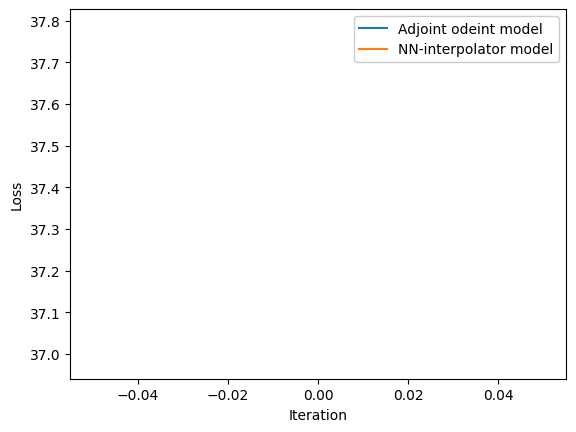

tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[7.6447e-09, 7.6441e-10, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2267e+01, 6.2442e+00, 1.1353e+01, 1.1365e+01, 2.9055e-01],
        [5.3172e+01, 6.8128e+00, 1.5952e+01, 1.7318e+01, 3.5658e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.2666, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.1721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([102.2686], dtype=torch.float64) tensor([73.5300], dtype=torch.float64)
tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[8.2381e-09, 8.2375e-10, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2252e+01, 6.2427e+00, 1.1368e+01, 1.1380e+01, 2.9148e-01],
        [5.3181e+01, 6.8112e+00, 1.5951e+01, 1.7317e+01, 3.5678e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.2519, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.1811, dtype=torch.float64, grad_fn=<

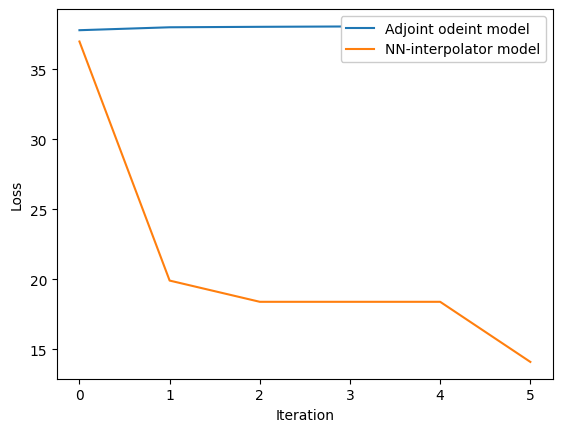

tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[1.5680e-08, 1.5679e-09, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2216e+01, 6.2393e+00, 1.1405e+01, 1.1416e+01, 2.9375e-01],
        [5.3203e+01, 6.8073e+00, 1.5947e+01, 1.7316e+01, 3.5726e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.2156, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.2027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([275.6609], dtype=torch.float64) tensor([78.0359], dtype=torch.float64)
tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[2.0062e-08, 2.0060e-09, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2209e+01, 6.2387e+00, 1.1411e+01, 1.1423e+01, 2.9416e-01],
        [5.3206e+01, 6.8066e+00, 1.5947e+01, 1.7315e+01, 3.5734e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.2092, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.2065, dtype=torch.float64, grad_fn=<

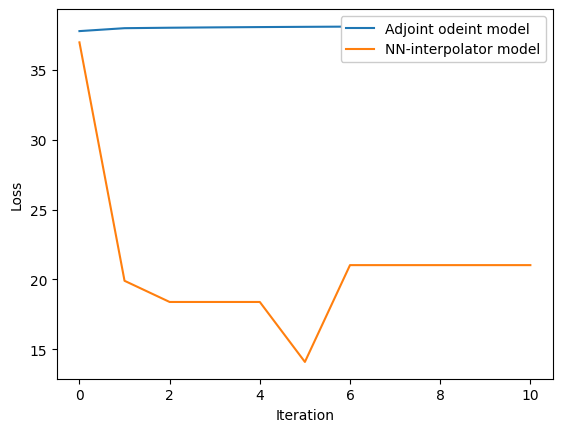

tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[8.3852e-08, 8.3846e-09, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2189e+01, 6.2367e+00, 1.1432e+01, 1.1444e+01, 2.9545e-01],
        [5.3219e+01, 6.8044e+00, 1.5945e+01, 1.7315e+01, 3.5760e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.1886, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.2187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([275.6609], dtype=torch.float64) tensor([78.0359], dtype=torch.float64)
tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[1.3000e-07, 1.2999e-08, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2184e+01, 6.2363e+00, 1.1436e+01, 1.1448e+01, 2.9572e-01],
        [5.3221e+01, 6.8040e+00, 1.5945e+01, 1.7314e+01, 3.5766e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.1843, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.2212, dtype=torch.float64, grad_fn=<

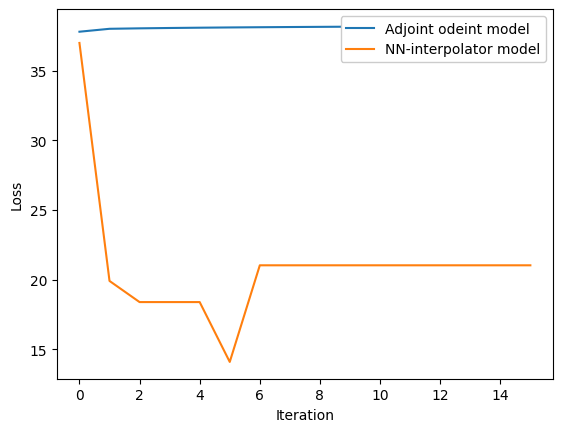

tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[7.8808e-06, 7.8803e-07, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2170e+01, 6.2349e+00, 1.1451e+01, 1.1463e+01, 2.9664e-01],
        [5.3230e+01, 6.8024e+00, 1.5943e+01, 1.7314e+01, 3.5784e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.1697, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.2297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([275.6609], dtype=torch.float64) tensor([78.0359], dtype=torch.float64)
tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[2.8189e-05, 2.8187e-06, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2167e+01, 6.2346e+00, 1.1453e+01, 1.1465e+01, 2.9679e-01],
        [5.3231e+01, 6.8022e+00, 1.5943e+01, 1.7314e+01, 3.5787e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.1673, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.2311, dtype=torch.float64, grad_fn=<

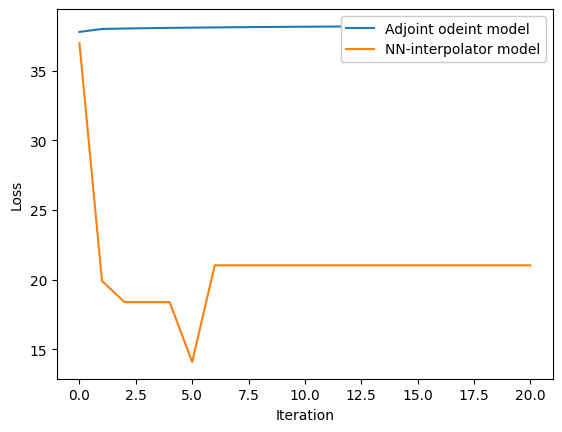

tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[2.2515e-02, 2.2514e-03, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2183e+01, 6.2365e+00, 1.1459e+01, 1.1471e+01, 2.9701e-01],
        [5.3248e+01, 6.8042e+00, 1.5948e+01, 1.7319e+01, 3.5800e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.1833, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.2480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([275.6609], dtype=torch.float64) tensor([78.0359], dtype=torch.float64)
tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[1.5256e-01, 1.5256e-02, 7.5000e+01, 7.5000e+01, 0.0000e+00],
        [6.2286e+01, 6.2469e+00, 1.1487e+01, 1.1499e+01, 2.9799e-01],
        [5.3346e+01, 6.8155e+00, 1.5975e+01, 1.7349e+01, 3.5872e+01]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(66.2858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(57.3463, dtype=torch.float64, grad_fn=<

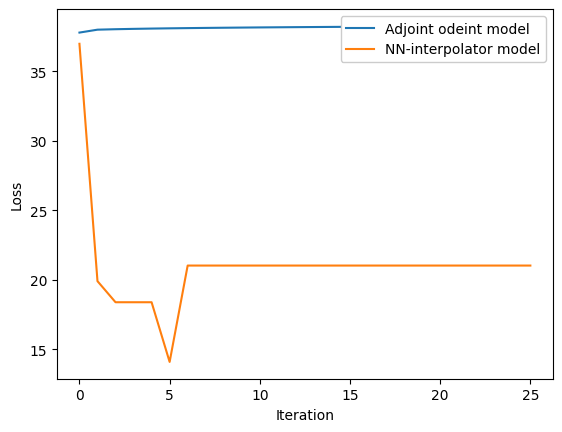

tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[155.2889,  15.5289,  75.0000,  75.0000,   0.0000],
        [193.3394,  19.3921,  35.9561,  35.9933,   0.9420],
        [165.9493,  21.1567,  49.6344,  53.9172, 111.8001]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(197.3394, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(169.9493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([275.6609], dtype=torch.float64) tensor([78.0359], dtype=torch.float64)
tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[227.8075,  22.7807,  75.0000,  75.0000,   0.0000],
        [254.5739,  25.5343,  47.4213,  47.4703,   1.2447],
        [218.6002,  27.8577,  65.3667,  71.0105, 147.3225]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(258.5739, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(222.6002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([275.6609], dtype=torch.float64) t

KeyboardInterrupt: 

In [7]:
model1 = NeuralODE()
model2 = Model2()
optimizer1 = optim.RMSprop(model1.parameters(), lr=1e-4)
optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-3)
losses1 = []
losses2 = []

for name, param in model1.named_parameters():
    print(f"Parameter {name} is on device: {param.device}")

for itr in range(150):

    ## TO CHANGE: change the next line to have input = processed video / batch viewed as torch tensor

    ## TO CHANGE: change the next line to have true_ved, true_ves, true_ef = true labels of the video / batch
    true_ved, true_ves, true_ef = torch.tensor(ved), torch.tensor(ves), torch.tensor(ef)

    input = torch.tensor([X[0], X[1], X[2], X[3]])
    print(input)
    #model1:
    optimizer1.zero_grad()
    pred_ved, pred_ves, pred_ef = model1(input)
    #loss1 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    loss1 = torch.abs(pred_ef - true_ef)
    loss1.backward()
    optimizer1.step()
    losses1.append(loss1.item())

    #model2:
    optimizer2.zero_grad()
    pred_ved, pred_ves, pred_ef = model2(input)
    #loss2 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    loss2 = torch.abs(pred_ef - true_ef)
    loss2.backward()
    optimizer2.step()
    losses2.append(loss2.item())

    if itr == 30: optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-4)
    if itr == 60: optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-5)

    if itr % 5 == 0:
      #print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss1.item()))
      plt.plot(np.arange(len(losses1)), losses1, label='Adjoint odeint model')
      plt.plot(np.arange(len(losses2)), losses2, label='NN-interpolator model')
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.legend(loc='upper right', framealpha=1)
      plt.show()

Train both models on a synthetic dataset of 400 patients (and 50 for testing) taken from the 450 results from the echonet dataset.

Create synthetic dataset:

In [8]:
n_patients = 450
inputs = torch.zeros(n_patients, 4)
labels = torch.zeros(n_patients, 3)

In [9]:
inputs[0][1], inputs[0][2] = 1., 10.
print(inputs[0])

tensor([ 0.,  1., 10.,  0.])


Get 450 random patients and create their inputs and labels:

In [10]:
output_path = '/content/drive/My Drive/'
file = 'input_450patients_echonet.pt'
inputs_dt = torch.load(output_path + file)
file = 'labels_450patients_echonet.pt'
labels_dt = torch.load(output_path + file)
print(inputs_dt, labels_dt)

for i in range(450):
  inputs[i][0], inputs[i][1], inputs[i][2], inputs[i][3] = inputs_dt[i][0], inputs_dt[i][1], inputs_dt[i][2], inputs_dt[i][3]
  labels[i][0], labels[i][1], labels[i][2] = labels_dt[i][0], labels_dt[i][1], labels_dt[i][2]

tensor([[ 85.8130,  53.6109, 100.9342, 127.3723],
        [ 86.4939,  54.5375, 103.0440, 130.5176],
        [ 74.7540,  51.3572, 100.0706, 125.7604],
        ...,
        [ 81.2824,  52.7348, 101.2469, 127.7181],
        [144.8227,  95.7740, 112.8991, 138.6498],
        [ 73.4291,  52.3870, 101.9269, 128.3651]]) tensor([[144.3182,  55.4956,  61.5464],
        [148.2538,  55.8099,  62.3552],
        [142.4189,  50.2441,  64.7209],
        ...,
        [144.8031,  53.1772,  63.2762],
        [154.8586, 100.6008,  35.0370],
        [145.6347,  50.0136,  65.6582]])


Using the data, train both models:

In [11]:
print(inputs_dt.shape)

torch.Size([450, 4])


<ipython-input-12-65e04d52949f>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype = torch.float64)
<ipython-input-12-65e04d52949f>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype = torch.float64)


tensor([[280.0000,  25.5591,  75.0000,  75.0000,   0.0000],
        [304.5175,  27.8784,  50.3715,  50.4219,   1.2791],
        [255.1170,  30.7393,  76.1077,  82.7095, 172.5311]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(308.5175, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(259.1170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([245.0549], dtype=torch.float64) tensor([62.8138], dtype=torch.float64)
tensor([[280.0000,  27.8369,  75.0000,  75.0000,   0.0000],
        [302.3463,  30.1354,  51.9761,  52.0251,   1.2421],
        [254.2611,  32.9164,  77.0392,  83.4665, 167.9671]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(306.3463, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(258.2611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([91.4226], dtype=torch.float64) tensor([69.6684], dtype=torch.float64)
tensor([[280.0000,  27.9449,  75.0000,  75.0000,   0.0000],
        [302.2439,  30.2416,  52.05

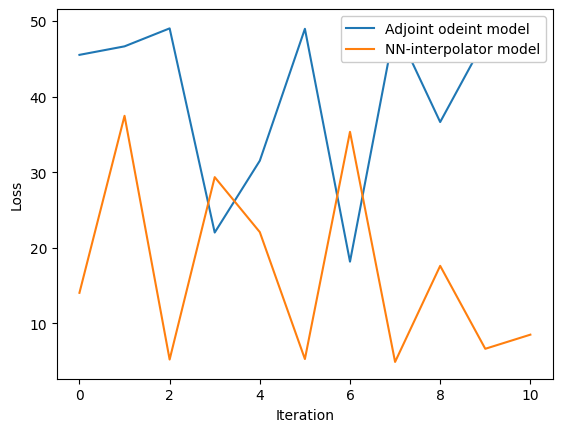

tensor([[280.0000,  27.9915,  75.0000,  75.0000,   0.0000],
        [302.2029,  30.2877,  52.0850,  52.1338,   1.2396],
        [254.2069,  33.0632,  77.1023,  83.5178, 167.6608]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(306.2029, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(258.2069, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([244.6963], dtype=torch.float64) tensor([76.3235], dtype=torch.float64)
tensor([[280.0000,  27.9994,  75.0000,  75.0000,   0.0000],
        [302.1952,  30.2955,  52.0910,  52.1398,   1.2395],
        [254.2015,  33.0708,  77.1071,  83.5222, 167.6483]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(306.1952, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(258.2015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([244.6963], dtype=torch.float64) tensor([76.3235], dtype=torch.float64)
tensor([[280.0000,  25.2466,  75.0000,  75.0000,   0.0000],
        [304.8232,  27.5666,  50.1

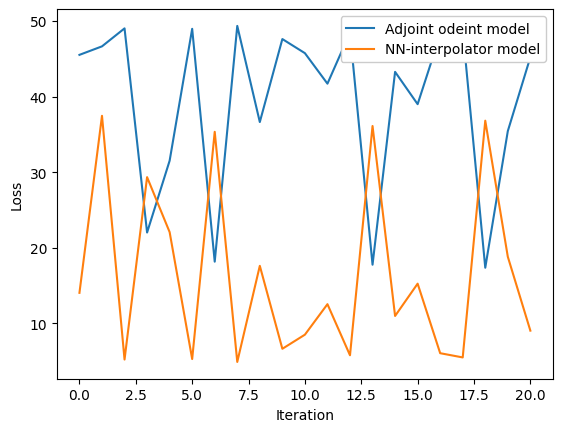

tensor([[280.0000,  27.9972,  75.0000,  75.0000,   0.0000],
        [302.1975,  30.2933,  52.0891,  52.1379,   1.2395],
        [254.2049,  33.0687,  77.1046,  83.5197, 167.6496]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(306.1975, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(258.2049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([244.6963], dtype=torch.float64) tensor([76.3235], dtype=torch.float64)
tensor([[280.0000,  27.9999,  75.0000,  75.0000,   0.0000],
        [302.1857,  30.2951,  52.1004,  52.1493,   1.2400],
        [254.1670,  33.0717,  77.1302,  83.5470, 167.7014]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(306.1857, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(258.1670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([244.6963], dtype=torch.float64) tensor([76.3235], dtype=torch.float64)
tensor([[280.0000,  27.6415,  75.0000,  75.0000,   0.0000],
        [302.5279,  29.9427,  51.8

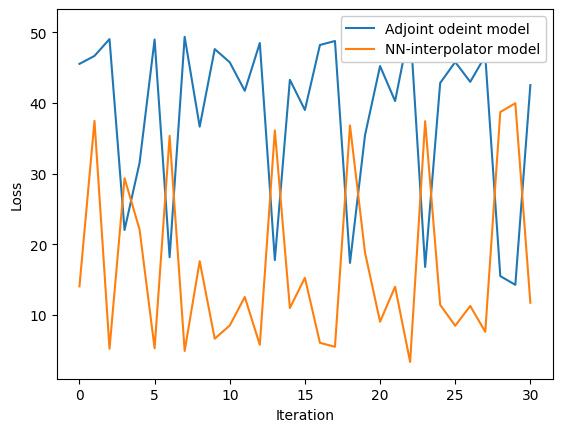

tensor([[280.0000,  27.8526,  75.0000,  75.0000,   0.0000],
        [302.3313,  30.1508,  51.9876,  52.0365,   1.2418],
        [254.2567,  32.9312,  77.0451,  83.4712, 167.9361]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(306.3313, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(258.2567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([244.6962], dtype=torch.float64) tensor([76.3236], dtype=torch.float64)
tensor([[280.0000,  27.7517,  75.0000,  75.0000,   0.0000],
        [302.4251,  30.0514,  51.9166,  51.9656,   1.2434],
        [254.2928,  32.8352,  77.0036,  83.4374, 168.1359]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(306.4251, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(258.2928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([244.6962], dtype=torch.float64) tensor([76.3235], dtype=torch.float64)
tensor([[280.0000,  27.9999,  75.0000,  75.0000,   0.0000],
        [302.1943,  30.2959,  52.0

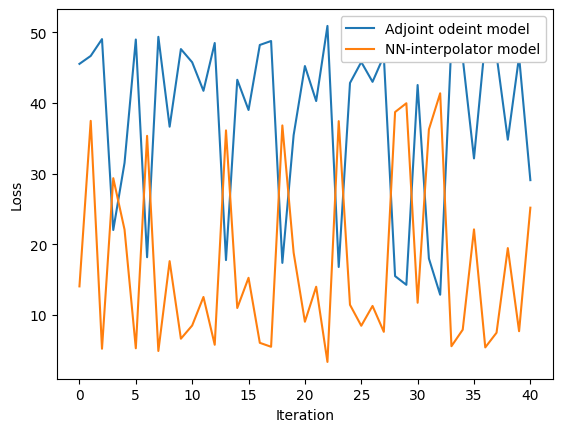

tensor([[280.0000,  27.9994,  75.0000,  75.0000,   0.0000],
        [302.1955,  30.2955,  52.0907,  52.1395,   1.2395],
        [254.2041,  33.0708,  77.1055,  83.5205, 167.6453]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(306.1955, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(258.2041, dtype=torch.float64, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [12]:
model1 = NeuralODE()
model2 = Model2()
optimizer1 = optim.RMSprop(model1.parameters(), lr=1e-4)
optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-3)
losses1 = []
losses2 = []

x_train = torch.zeros((400, 4))
y_train = torch.zeros((400, 1))
for i in range(400):
  x_train[i][0], x_train[i][1], x_train[i][2], x_train[i][3] = inputs[i][0], inputs[i][1], inputs[i][2], inputs[i][3]
  y_train[i][0] = labels[i][2]
x_train = torch.tensor(x_train, dtype = torch.float64)
y_train = torch.tensor(y_train, dtype = torch.float64)
n_itrs = 400

for itr in range(n_itrs):
    ## TO CHANGE: change the next line to have input = processed video / batch viewed as torch tensor

    ## TO CHANGE: change the next line to have true_ved, true_ves, true_ef = true labels of the video / batch
    true_ved, true_ves, true_ef = torch.tensor(ved), torch.tensor(ves), torch.tensor(ef)

    j = itr #random.randint(0,400)

    optimizer1.zero_grad()
    pred_ved, pred_ves, pred_ef = model1(x_train[j])
    #loss1 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    loss1 = torch.abs(pred_ef - y_train[j][0])
    loss1.backward()
    optimizer1.step()
    losses1.append(loss1.item())

    optimizer2.zero_grad()
    #loss2 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    pred_ved, pred_ves, pred_efs = model2(x_train[j])
    loss2 = torch.abs(pred_efs - y_train[j][0])
    loss2.backward()
    optimizer2.step()
    losses2.append(loss2.item())

    if itr == 35: optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-5)
    if itr == 60: optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-6)

    if itr % 10 == 0 and itr>0:
      #print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss1.item()))
      plt.plot(np.arange(len(losses1)), losses1, label='Adjoint odeint model')
      plt.plot(np.arange(len(losses2)), losses2, label='NN-interpolator model')
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.legend(loc='upper right', framealpha=1)
      plt.show()

In [13]:
print(itr)

41
